In [0]:
!pip install -q git+https://www.github.com/google/neural-tangents
import neural_tangents as nt
from neural_tangents import stax


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax.numpy as jnp
from jax import random
from jax.api import jit, grad, vmap
from jax.experimental import optimizers
from jax import device_put
import timeit
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from functools import partial
import scipy as sp
import scipy.special
import math
import tensorflow as tf
import sys
import sklearn
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# process the data 
def process_data(batch_block):
  image, label = batch_block['image'], batch_block['label']
  samples = image.shape[0]
  image = tf.image.rgb_to_grayscale(image).numpy()
  image = jnp.reshape(image, (image.shape[0], 32*32))
  image = jnp.array(image, dtype = np.float32)
  label = jnp.eye(10)[label]
  return {'image': image, 'label': label}


batch_size = 128
training_epochs = 5
test_data = tfds.load('cifar10', split=tfds.Split.TEST)
train_data = tfds.load('cifar10', split=tfds.Split.TRAIN)
train_data_shuff = tfds.as_numpy(
    train_data.shuffle(1024).batch(batch_size).repeat(training_epochs))
test_data_shuff = tfds.as_numpy(
    train_data.shuffle(1024).batch(batch_size))



/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incompleteYXLJII/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incompleteYXLJII/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.0. Subsequent calls will reuse this data.


In [0]:
# let's just do vanilla CNN
def ConvolutionalNetwork(depth, channels):
  layers = []
  for _ in range(depth):
    layers += [stax.Conv(channels, (3, 3), padding='SAME'), stax.Relu()]
  layers += [stax.Flatten(), stax.Dense(10)]
  return stax.serial(*layers)

def FullyConnected(depth, width):
  layers = []
  for _ in range(depth):
    layers += [stax.Dense(width), stax.Relu()]
  layers += [stax.Dense(10)]
  return stax.serial(*layers)


depth = 3
channels = 1000

# init_fn gives parameters; apply_fn computes NN output, kernel_fn: infinite #channels limit
#init_fn, apply_fn, kernel_fn = ConvolutionalNetwork(depth, channels)
init_fn, apply_fn, kernel_fn = FullyConnected(depth, channels)



key = random.PRNGKey(2020)


In [0]:
# get initial parameters
_, params = init_fn(key, (-1, 1024))

# define optimizer 
lr = 1e-2
opt_init, opt_update, get_params = optimizers.adam(lr)

# define a supervised loss 
nn_loss = jit(lambda params, X, y: jnp.mean((apply_fn(params, X) - y )**2 ))
grad_loss = jit(lambda state, x, y: grad(nn_loss)(get_params(state), x, y))

soft_max = jit(lambda z: jnp.exp(z) / jnp.outer(jnp.sum(jnp.exp(z), axis=1), jnp.ones(z.shape[1])))
predict = jit(lambda params, X: soft_max(apply_fn(params, X)))
nn_loss_cross = jit(lambda params, X, y: - jnp.mean(y * jnp.log(predict(params, X))))
grad_loss_cross = jit(lambda state, x, y: grad(nn_loss_cross)(get_params(state), x, y))

In [0]:
M = 1000
train_blocks = tfds.as_numpy(train_data.shuffle(1024).batch(M))

all_data = np.zeros((50000, 1024))
all_labels = np.zeros((50000, 10))
for i, batch in enumerate(train_blocks):
  data = process_data(batch)
  image = data['image']
  label = data['label']
  all_data[i*M:(i+1)*M,:] = image / 255.
  all_labels[i*M:(i+1)*M,:] = label




In [0]:
images = []
labels = []
for data in test_data_shuff:
  data_i = process_data(data)
  image = data_i['image'] / 255.
  label = data_i['label']
  images.append(image)
  labels.append(label)

test_images = np.concatenate(images)
test_labels = np.concatenate(labels)

## try kernel method (covariance between test and train)

In [0]:
test_data = tfds.load('cifar10', split=tfds.Split.TEST)
train_data = tfds.load('cifar10', split=tfds.Split.TRAIN)
train_data_shuff = tfds.as_numpy(
    train_data.shuffle(1024).batch(1))
test_data_shuff = tfds.as_numpy(
    test_data.shuffle(1024).batch(1))

In [0]:
train_images = []
train_labels = []
for i, a in enumerate(train_data_shuff):
  if i == 40:
    break
  image = a["image"]/255
  label = jnp.eye(10)[a["label"]]
  train_images.append(image)
  train_labels.append(label)

In [0]:
#from neural_tangents import stax
def WideResnetBlock(channels, strides=(1, 1), channel_mismatch=False):
  Main = stax.serial(
      stax.Relu(), stax.Conv(channels, (3, 3), strides, padding='SAME'),
      stax.Relu(), stax.Conv(channels, (3, 3), padding='SAME'))
  Shortcut = stax.Identity() if not channel_mismatch else stax.Conv(
      channels, (3, 3), strides, padding='SAME')
  return stax.serial(stax.FanOut(2),
                     stax.parallel(Main, Shortcut),
                     stax.FanInSum())

def WideResnetGroup(n, channels, strides=(1, 1)):
  blocks = []
  blocks += [WideResnetBlock(channels, strides, channel_mismatch=True)]
  for _ in range(n - 1):
    blocks += [WideResnetBlock(channels, (1, 1))]
  return stax.serial(*blocks)

def WideResnet(block_size, k, num_classes):
  return stax.serial(
      stax.Conv(16, (3, 3), padding='SAME'),
      WideResnetGroup(block_size, int(16 * k)),
      WideResnetGroup(block_size, int(32 * k), (2, 2)),
      WideResnetGroup(block_size, int(64 * k), (2, 2)),
      stax.AvgPool((8, 8)),
      stax.Flatten(),
      stax.Dense(num_classes, 1., 0.))

init_fn, apply_fn, kernel_fn = WideResnet(block_size=4, k=1, num_classes=10)

In [0]:
ntk = kernel_fn(train_images[0], train_images[1], 'ntk')

/usr/local/lib/python3.6/dist-packages/neural_tangents/stax.py:2345: UserWarning: `FanIn` layers assume independent inputs which is not verified in the code. Please make sure to have at least one `Dense` / `Conv` / `GlobalSenfAttention` etc. layer in each branch.
  warnings.warn('`FanIn` layers assume independent inputs which is not verified'


In [0]:
train_images_10 = all_data[:10, :]
train_labels_10 = all_labels[:10]
test_images_10 = all_data[10:20, :]
test_labels_10 = all_labels[10:20, :]

In [0]:
init_fn, apply_fn, kernel_fn = FullyConnected(40, 128)

In [0]:
y_test_ntk = nt.predict.gp_inference(kernel_fn, train_images[0], train_labels[0], train_images[1], get='ntk')

/usr/local/lib/python3.6/dist-packages/neural_tangents/stax.py:2345: UserWarning: `FanIn` layers assume independent inputs which is not verified in the code. Please make sure to have at least one `Dense` / `Conv` / `GlobalSenfAttention` etc. layer in each branch.
  warnings.warn('`FanIn` layers assume independent inputs which is not verified'


In [0]:
y_test_ntk

DeviceArray([[0.       , 0.       , 0.7584808, 0.       , 0.       ,
              0.       , 0.       , 0.       , 0.       , 0.       ]],            dtype=float32)

In [0]:
train_labels[1]

DeviceArray([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
sum(np.argmax(test_labels_10, axis=1) == np.argmax(y_test_ntk, axis=1))

2

In [0]:
y_test_nngp = nt.predict.gp_inference(kernel_fn, train_images_10, train_labels_10, 
                                      test_images_10, get='nngp')
# (20, 1) np.ndarray test predictions of an infinite Bayesian network



In [0]:
test_labels_10

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

2

In [0]:
np.argmax(y_test_ntk, axis=1)

array([7, 2, 7, 7, 4, 4, 7, 4, 2, 4])

In [0]:
np.argmax(y_test_nngp, axis=1)

array([7, 2, 7, 9, 2, 4, 7, 6, 2, 4])

In [0]:
import numpy as npo
x_train = npo.zeros((60000,784))

In [0]:
x_train.shape

(60000, 784)

In [0]:
t_vals = np.arange(0,10,0.25)

In [0]:
t_vals

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
       5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ,
       8.25, 8.5 , 8.75, 9.  , 9.25, 9.5 , 9.75])

In [0]:
K = kernel_fn(train_images_10,train_images_10,get='ntk')
eigvals = np.sort(np.linalg.eigvalsh(K))[::-1]
predictor = nt.predict.gradient_descent_mse(K, train_labels_10)
predictor(test_images_10)

ValueError: ignored

In [0]:
# BLOCK OF CODE TO DO GRID SEARCH EXPERIMENTS

def train_network(params):
  opt_state = opt_init(params)
  train_losses = []
  for i, batch in enumerate(train_data_shuff):
    data_i = process_data(batch)
    image = data_i['image'] / 255.
    label = data_i['label']
    opt_state = opt_update(i, grad_loss_cross(opt_state, image, label), opt_state)
    train_loss_i = nn_loss_cross(get_params(opt_state), image, label)
    train_losses.append(train_loss_i)
    sys.stdout.write('\rtrain loss: %0.5f' % train_loss_i)
    sys.stdout.flush()
  return opt_state, train_loss_i

widths = [128, 256, 512]
layers = [2,5,10,12,15,20,50]

model_combos = []
train_errors = []
test_errors = []
train_times = []

for n in layers:
  for width in widths:
    print(f"Depth {n}\tWidth {width}")
    init_fn, apply_fn, kernel_fn = FullyConnected(n, width)
    key = random.PRNGKey(2020)
    _, params = init_fn(key, (-1, 1024))
    start = timeit.default_timer()
    train_data_shuff = tfds.as_numpy(
      train_data.shuffle(1024).batch(batch_size).repeat(training_epochs))
    opt_state, train_error = train_network(params)
    end = timeit.default_timer()
    train_time = end - start
    print("\nTraining Time: %0.5f" %train_time)
    test_preds = predict(get_params(opt_state), test_images)
    preds = np.argmax(test_preds, axis = 1).astype('int')
    true = np.argmax(test_labels, axis = 1).astype('int')
    gen_err = 1 - (preds==true).mean()
    print("Test Classification Error: %0.5f" %gen_err)
    model_combos.append((n, width))
    train_errors.append(train_error)
    test_errors.append(gen_err)
    train_times.append(train_time)

Depth 2	Width 128
train loss: 0.17456
Training Time: 87.43318
Test Classification Error: 0.62294
Depth 2	Width 256
train loss: 0.16607
Training Time: 85.86001
Test Classification Error: 0.60326
Depth 2	Width 512
train loss: 0.17207
Training Time: 87.57699
Test Classification Error: 0.59456
Depth 5	Width 128
train loss: 0.15937
Training Time: 134.55819
Test Classification Error: 0.62534
Depth 5	Width 256
train loss: 0.16423
Training Time: 134.81600
Test Classification Error: 0.59700
Depth 5	Width 512
train loss: 0.15730
Training Time: 137.36587
Test Classification Error: 0.58382
Depth 10	Width 128
train loss: 0.17891
Training Time: 221.97269
Test Classification Error: 0.65010
Depth 10	Width 256
train loss: 0.16614
Training Time: 219.05926
Test Classification Error: 0.63524
Depth 10	Width 512
train loss: 0.15321
Training Time: 221.06299
Test Classification Error: 0.62328
Depth 12	Width 128
train loss: 0.18038
Training Time: 251.15806
Test Classification Error: 0.67288
Depth 12	Width 256


In [0]:
model_combos = np.hstack(model_combos)
train_errors = np.hstack(train_errors)
test_errors = np.hstack(test_errors)
train_times = np.hstack(train_times)

# np.save("drive/My Drive/cifar10_model_combos.npy", model_combos)
# np.save("drive/My Drive/cifar10_train_errors.npy", train_errors)
# np.save("drive/My Drive/cifar10_test_errors.npy", test_errors)
# np.save("drive/My Drive/cifar10_train_times.npy", train_times)

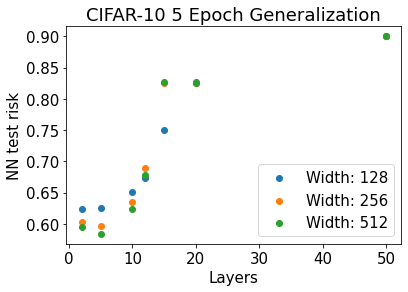

In [0]:
test_errors = np.load("drive/My Drive/cifar10_test_errors.npy")
shaped_err = test_errors.reshape(-1,3)
plt.rcParams.update({'font.size': 15})
plt.scatter(layers, shaped_err[:,0], label="Width: 128")
plt.scatter(layers, shaped_err[:,1], label="Width: 256")
plt.scatter(layers, shaped_err[:,2], label="Width: 512")
plt.xlabel("Layers")
plt.ylabel("NN test risk")
plt.legend()
plt.title("CIFAR-10 5 Epoch Generalization")
plt.savefig("drive/My Drive/cifar10_plot_class.pdf")

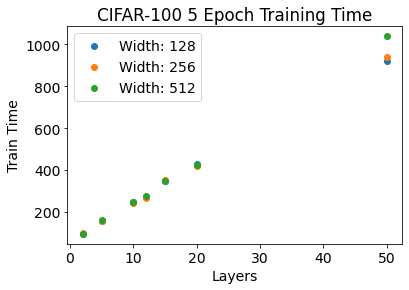

In [0]:
train_times = np.load("drive/My Drive/cifar100_train_times.npy")
shaped_times = train_times.reshape(-1,3)
plt.rcParams.update({'font.size': 14})
plt.scatter(layers, shaped_times[:,0], label="Width: 128")
plt.scatter(layers, shaped_times[:,1], label="Width: 256")
plt.scatter(layers, shaped_times[:,2], label="Width: 512")
plt.xlabel("Layers")
plt.ylabel("Train Time")
plt.legend()
plt.title("CIFAR-100 5 Epoch Training Time")
plt.savefig("drive/My Drive/cifar100_trainingtime.pdf")

In [0]:
# Get kernel of a single type
nngp = kernel_fn(x1, x2, 'nngp') # (10, 20) np.ndarray
ntk = kernel_fn(x1, x2, 'ntk') # (10, 20) np.ndarray

# Get kernels as a namedtuple
both = kernel_fn(x1, x2, ('nngp', 'ntk'))
both.nngp == nngp  # True
both.ntk == ntk  # True

# Unpack the kernels namedtuple
nngp, ntk = kernel_fn(x1, x2, ('nngp', 'ntk'))

In [0]:
def kernel_2_layer(z):
  return z*(1 - 1/math.pi*jnp.arccos(z)) + 1/math.pi * jnp.sqrt(1-z**2)

def f_relu(phi, L):
    if L==1:
        return np.arccos(1/math.pi * np.sin(phi) + (1 - 1/math.pi *  np.arccos(np.cos(phi))   )   * np.cos(phi))
    elif L==0:
        return np.arccos(np.cos(phi))
    else:
        return f(phi,L-1)
    
def kernel(z, layers):
  if layers == 1:
    return kernel_2_layer(z)
  
  else:
    a = np.arccos(z)
    for i in range(L-1):
      a = f(a,1)
    return np.cos(f(a,1)) + kernel(z,L-1) * (1-a/math.pi) 


In [0]:
M = 1000
train_blocks = tfds.as_numpy(train_data.shuffle(1024).batch(M))
test_blocks = tfds.as_numpy(train_data.shuffle(1024).batch(M))


all_data = np.zeros((50000, 1024))
all_labels = np.zeros((50000, 10))
all_test_data = np.zeros((50000, 1024))
all_test_labels = np.zeros((50000, 10))

for i, batch in enumerate(train_blocks):
  data = process_data(batch)
  image = data['image']
  label = data['label']
  all_data[i*M:(i+1)*M,:] = image / np.outer(np.linalg.norm(image, axis = 1), (1+1e-6)*np.ones(image.shape[1]))
  all_labels[i*M:(i+1)*M,:] = label

for i, batch in enumerate(test_blocks):
  data = process_data(batch)
  image = data['image']
  label = data['label']
  all_test_data[i*M:(i+1)*M,:] = image / np.outer(np.linalg.norm(image, axis = 1), (1+1e-6)*np.ones(image.shape[1]))
  all_test_labels[i*M:(i+1)*M,:] = label



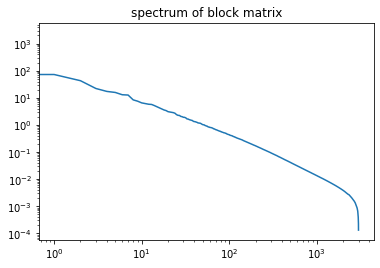

KeyboardInterrupt: ignored

In [0]:
# do an experiment on a block of size 5000
block_size = 3000
K = kernel_2_layer(np.dot(all_data[0:block_size,:], all_data[0:block_size,:].T ))
#K = kernel_fn(all_data[0:block_size, :], get='ntk')
k = 250
T = 500

y_block = all_labels[0:block_size,:]

w,v = sp.linalg.eigh(K, eigvals=(0, block_size-1))
w = w[::-1]
v = v[:,::-1]
plt.loglog(w)
plt.title('spectrum of block matrix')
plt.show()


#P = np.eye(block_size) + v @ (-np.eye(k) + w[k-1] * np.diag(w**(-1)) ) @ v.T

P = np.eye(block_size)
for i in range(k):
  P += (w[k-1]/w[i] - 1) * np.outer(v[:,i],v[:,i])

wp,vp = sp.linalg.eigh(P)
plt.loglog(wp[::-1])
plt.title('P spectrum')
plt.show()
y_P = P @ y_block
K_P = P @ K

wp,vp= sp.linalg.eigh(K_P, eigvals=(0, block_size-1))

plt.loglog(wp[::-1], label = 'eigenpro')
plt.loglog(w, label = 'original spectrum')
plt.title('comparison of spectra')
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.savefig('/content/gdrive/My Drive/eigpro_spectrum.pdf')
plt.show()

alpha = np.zeros((block_size, 10))
alpha_slow = np.zeros((block_size, 10))
eta = 0.99/(w[k-1])
err = np.zeros(T)
err_slow = np.zeros(T)
alpha_star = np.linalg.inv(K) @ y_block
true_err = np.zeros(T)
true_err_slow = np.zeros(T)
eta_slow = 1/w[0]
for i in range(T):
  true_err[i] = np.mean( (K @ alpha - y_block)**2 )
  true_err_slow[i] = np.mean( (K @ alpha_slow - y_block)**2 )

  alpha += eta*(y_P - K_P@alpha)
  alpha_slow += eta_slow*(y_block - K @ alpha)
  err[i] = np.mean((alpha- alpha_star)**2)
  err_slow[i] = np.mean( (alpha_slow-alpha_star)**2 )
  
  sys.stdout.write( "\r size of alpha: %.7f | preconditioned error: %.7f | naive error: %.7f" % (np.mean((alpha**2)) , true_err[i], true_err_slow[i]) )

plt.semilogy(np.sqrt(true_err), label = 'preconditioned')
plt.semilogy(np.sqrt(true_err_slow), label = 'naive GD')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel(r'$||K \alpha - y ||$')
plt.title('Preconditioned Training Dynamics')
plt.savefig('/content/gdrive/My Drive/eigpro_error.pdf')
plt.show()

# some possible plots: 1. number of required steps vs k ; 2. ops(k) / n^3 vs k 

In [0]:
# write code to iterate through blocks


def train_blocks(all_data, all_labels, block_size, k):
  
  all_data =  all_data / np.outer(jnp.linalg.norm(all_data,axis = 1), (1+1e-3)*jnp.ones(all_data.shape[1])) 
  # get preconditioner from first block
  X = all_data[0:block_size,:]
  start = timeit.default_timer()
  K_1 = kernel_2_layer(X @ X.T)
  end = timeit.default_timer()
  print("time without jit %.5f" %( end - start))
  w,v = sp.linalg.eigh(K_1, eigvals = (0, block_size -1))
  w = w[::-1]
  v = v[:,::-1]

  #w = all_data.shape[0] / block_size * w

  # compute preconditioner and learning rate
  P = np.eye(block_size)
  for i in range(k):
    P += (w[k-1]/w[i] - 1) * np.outer(v[:,i],v[:,i])
  

  wp, vp = sp.linalg.eigh(P @ K_1, eigvals=(0,block_size-1))
  K_sub = K_1[0:k,0:k]
  wsub, vsub = sp.linalg.eigh(K_sub)
  plt.loglog(w)
  plt.loglog(wp[::-1])
  plt.loglog(block_size/k * wsub[::-1])
  plt.show()
  

  eta = 0.9/np.amax(wp)
  eta_slow = 1/np.amax(w)
  T = 200
  alpha = np.zeros((all_data.shape[0], 10))
  err = np.zeros(T)
  err_after = np.zeros(T)
  err_slow = np.zeros(T)

  P = jnp.array(P)
  


  get_kernel = jit(lambda X, Xp: kernel_2_layer(jnp.dot(X, Xp.T)))
  get_res = jit(lambda K, alpha, y: y - jnp.dot(K, alpha))
  get_update = jit(lambda eta, P, res: eta* jnp.dot(P, res))
  err_fn = jit(lambda K, alpha, y: np.mean(get_res(K,alpha, y)**2 ) )
  update_alpha = jit(lambda alpha, g: alpha+g)

  K_1_jit = get_kernel(X,X)
  start = timeit.default_timer()
  K_1_jit = get_kernel(X,X)
  end = timeit.default_timer()
  print("time jit: %.7f" % (end-start))
  print( jnp.mean( (K_1_jit-K_1)**2 ) )


  alpha = np.zeros( (block_size,10))
  alpha_slow = np.zeros( (block_size, 10))
  X = all_data[0:block_size,:]
  K = get_kernel(X,X)
  y = all_labels[0:block_size,:]
  start_opt = timeit.default_timer()

  T = 200
  err = np.zeros(T)
  for t in range(T):
    res = get_res(K, alpha, y)
    g = get_update(eta, P, res)
    g_slow = get_update(eta_slow, np.eye(block_size), res)
    err[t] = err_fn(K, alpha, y)
    err_slow[t] = err_fn(K, alpha_slow, y)
    alpha += g
    alpha_slow += g_slow
    
    sys.stdout.write("\rerror: %.7f | error slow: %.7f" % (err[t], err_slow[t]))
  end_opt = timeit.default_timer()
  print("time to optimize = %.7f" % (end_opt-start_opt))
  plt.semilogy(err)
  plt.semilogy(err_slow)
  plt.show()

  T=800
  w_tot = all_data.shape[0] / block_size * w
  eta = 100/np.amax(w_tot)
  err = np.zeros(T)
  alpha = np.zeros((block_size,10))
  counter = 0
  num_block = int(all_data.shape[0] / block_size)
  update = np.zeros((block_size,10))
  for t in range(T):
    X = all_data[0:block_size,:]
    y = all_labels[0:block_size,:]
    K = get_kernel(X, X)
    res = get_res(K, alpha, y)
    g = get_update(eta, P, res)
    update[0:block_size,:] += g
    #alpha[counter*block_size:(counter+1)*block_size,:] += g
    err[t] = err_fn(K, alpha, y)
    sys.stdout.write("\r counter: %d | error: %.7f | alpha size: %.7f" % (counter, err[t], jnp.mean(alpha**2)))
    counter += 1
    counter = counter % num_block
    if counter %1 ==0:
      alpha += update
      update = np.zeros(alpha.shape)
  

  plt.semilogy(err)
  plt.show()



  """
  for t in range(T):
    index_start = t*block_size %all_data.shape[0]
    print("start: %d" % index_start)
    X = all_data[index_start:index_start+block_size, :]
    y = all_labels[index_start:index_start+block_size,:]
    K_m = get_kernel(X,all_data)
    err[t] = err_fn(K_m, alpha, y)
    print(jnp.isnan(K_m).sum())
    res = get_res(K_m, alpha, y)
    g = get_update(eta, P, res)
    alpha[index_start:index_start+block_size,:] += 1/block_size *g
    err_after[t] = err_fn(K_m, alpha, y)
    delta_alpha = jnp.sqrt( jnp.mean( (alpha)**2) )
    print("change in alpha: %0.7f" % delta_alpha)
    print("error: %.7f | error after update: %.7f" % (err[t],err_after[t]))

  plt.loglog(err)
  plt.show()
  """
  return alpha


time without jit 0.75917


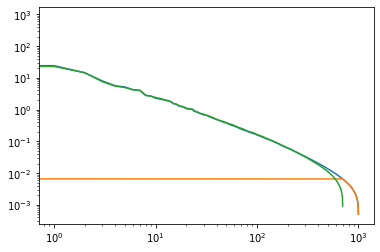

time jit: 0.0031273
1.2901751e-13
error: 0.0000002 | error slow: 0.0899210time to optimize = 1.5359108


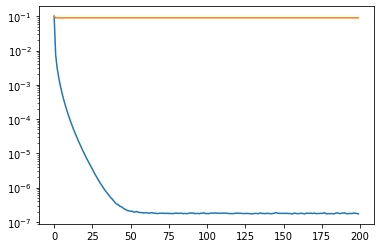

 counter: 49 | error: 0.0978296 | alpha size: 0.1152640

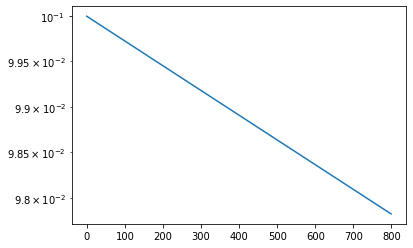

In [0]:
block_size = 1000
k = 700
alpha = train_blocks(all_data, all_labels, block_size, k)


In [0]:
def eigenpro_sub_update(all_data, all_labels, block_size, eig_block_size, k):
  # do a subset for now
  
  all_data =  all_data / np.outer(jnp.linalg.norm(all_data,axis = 1), (1+1e-3)*jnp.ones(all_data.shape[1])) 
  #all_data = all_data[0:5000,:]
  #all_labels = all_labels[0:5000,:]
  
  get_kernel = jit(lambda X, Xp: kernel_2_layer(jnp.dot(X, Xp.T)))
  get_res = jit(lambda K, alpha, y: y - jnp.dot(K, alpha))
  speedy_dot = jit(lambda a, b: jnp.dot(a,b))
  mse = jit(lambda res: jnp.mean(res**2))

  X_s = all_data[0:eig_block_size,:]
  K_s = get_kernel(X_s,X_s)
  w_s, v_s = sp.linalg.eigh(K_s, eigvals = (eig_block_size-1-k,eig_block_size-1))
  w_s = w_s[::-1]
  v_s = v_s[:,::-1]
  plt.loglog(w_s)
  plt.show()

  #P = v_s@  np.diag(w_s**(-1)) @ (np.eye(k+1) - w_s[-1]*np.diag(w_s**(-1)) ) @ v_s.T
  P = speedy_dot(v_s, speedy_dot(np.diag(w_s**(-1)), speedy_dot( (np.eye(k+1) - w_s[-1]*np.diag(w_s**(-1))), v_s.T ) ) )
  #P = v_s @(np.eye(k+1) - w_s[-1]*np.diag(w_s**(-1)) ) @ v_s.T


  T = 5000
  alpha = np.zeros(all_labels.shape)
  errs = np.zeros(T)
  print(w_s[-1])
  #eta = 0.8/w_s[-1]
  eta = 850/ w_s[-1]
  print("eta = %.6f" %eta)
  for t in range(T):
    start = (t * block_size) % all_data.shape[0] 
    if start == 0:
      print("\n new epoch")
    X_m = all_data[start:start+block_size,:]
    y_m = all_labels[start:start+block_size,:]
    K_m = get_kernel(X_m, all_data)
    res = get_res(K_m, alpha, y_m)
    alpha[start:start+block_size,:] += eta/block_size * res
    K2 = get_kernel(X_s,X_m)
    #alpha[0:block_size,:] +=  eta/block_size * jnp.dot(jnp.dot(P, K2), res)
    alpha[0:eig_block_size,:] += - eta/block_size * speedy_dot(P, speedy_dot(K2, res))
    train_err = 10*mse(res)
    res2 = get_res(K_m, alpha, y_m)
    train2 = 10*mse(res2)
    alpha_norm = mse(alpha)
    sys.stdout.write('\r train err: %.8f | train after %.8f | alpha norm %.8f' % (train_err, train2, alpha_norm) )
    errs[t] = train_err
  
  plt.semilogy(errs)
  plt.show()

  return alpha

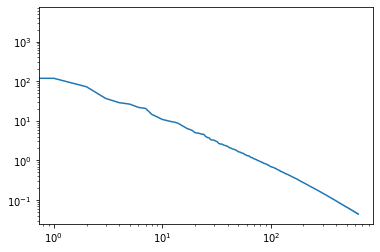

0.04408534
eta = 19280.786421

 new epoch
 train err: 0.76411033 | train after 0.76411033 | alpha norm 8.49267387
 new epoch
 train err: 0.67134821 | train after 0.67134821 | alpha norm 27.50923157
 new epoch
 train err: 0.69678336 | train after 0.69678336 | alpha norm 57.65205765
 new epoch
 train err: 0.56006503 | train after 0.56006503 | alpha norm 97.03254700
 new epoch
 train err: 0.52126133 | train after 0.52126133 | alpha norm 144.76057434
 new epoch
 train err: 0.51048928 | train after 0.51048928 | alpha norm 200.11865234
 new epoch
 train err: 0.46373099 | train after 0.46373099 | alpha norm 262.51751709
 new epoch
 train err: 0.43883121 | train after 0.43883121 | alpha norm 331.51794434
 new epoch
 train err: 0.41925299 | train after 0.41925299 | alpha norm 406.58587646
 new epoch
 train err: 0.41628274 | train after 0.41628274 | alpha norm 487.19009399
 new epoch
 train err: 0.38142782 | train after 0.38142782 | alpha norm 573.09674072
 new epoch
 train err: 0.36779317 | tra

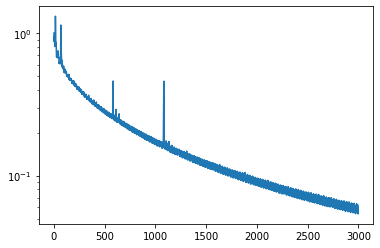

In [0]:
block_size = 2000
eig_block_size = 5000
k = 640
alpha = eigenpro_sub_update(all_data, all_labels, block_size, eig_block_size, k)



# Finite neural network training (Pytorch)

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import sys


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5000,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5000,
                                         shuffle=False, num_workers=2)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class FCmodel(nn.Module):
    def __init__(self, num_layers, num_nodes):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.model  = nn.Sequential(
            nn.Linear(3*32*32, num_nodes), 
            nn.ReLU()
        )
        for i in range(1, num_layers):
          self.model.add_module("fc" + str(i), nn.Linear(num_nodes, num_nodes))
          self.model.add_module("relu" + str(i), nn.ReLU())
        self.model.add_module("output", nn.Linear(num_nodes, 10))
        
    def forward(self, x):
        x = x.reshape((-1, 3*32*32))
        # define forward pass
        x = self.model(x)
        return x

In [0]:
import numpy as np
def training_to_zero_loss(model, trainloader, testloader, train_losses, epoch_train_accs, criterion, optimizer, scheduler):
  start = timeit.default_timer()
  while True:
    model.train()
    scheduler.step()
    #print('Epoch:', epoch,'LR:', scheduler.get_lr())
    train_accs = []
    for i, batch in enumerate(trainloader):
      optimizer.zero_grad()
      inputs, labels = batch
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
      #sys.stdout.write('\rtrain loss: %0.4f' % loss)
      #sys.stdout.flush()
      _, predicted = torch.max(outputs.data, 1)
      train_acc = (predicted == labels).sum().item()/labels.size(0)
      train_accs.append(train_acc)
      sys.stdout.write('\rtrain acc: %0.4f' % train_acc)
      sys.stdout.flush()
    epoch_train_acc = np.mean(train_accs)
    print("  epoch train acc is", epoch_train_acc)
    epoch_train_accs.append(epoch_train_acc)
    if (len(epoch_train_accs) >= 5) and (np.mean(epoch_train_accs[-5:]) >= 0.8):
      end = timeit.default_timer()
      train_time = end - start
      return train_time

  end = timeit.default_timer()
  train_time = end - start
  return train_time

def evaluation(model, dataloader):
  model = model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  return correct/total

In [0]:
widths = [128, 256, 512]
layers = [2,5,10,12,15, 20, 50]
info_dict = {}
for layer in layers:
  for width in widths:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=500, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False)
    print("layer", layer, "width", width)
    info_dict["combo"] = [layer, width]
    model = FCmodel(layer, width)
    model = model.to(device)#
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)
    train_losses = []
    epoch_train_accs = []
    training_time = training_to_zero_loss(model, trainloader, testloader, 
                                          train_losses, epoch_train_accs, 
                                          criterion, optimizer, scheduler)
    info_dict["epoch_train_accs"] = epoch_train_accs
    info_dict["train_losses"] = train_losses
    print("training time is", training_time)
    info_dict["train_time"] = training_time
    test_acc = evaluation(model, testloader)
    print("testing acc is", test_acc)
    info_dict["test_acc"] = test_acc
    filename = str(layer) + "_" + str(width)
    with open("drive/My Drive/kernel_method_files/pytorch_cifar10_90pa_" + filename + "_info.pkl", "wb") as f:
      pickle.dump(info_dict, f)

# Finite neural network traning (jax)

In [0]:
soft_max = jit(lambda z: jnp.exp(z) / jnp.outer(jnp.sum(jnp.exp(z), axis=1), jnp.ones(z.shape[1])))
predict = jit(lambda params, X: soft_max(apply_fn(params, X)))
nn_loss_cross = jit(lambda params, X, y: - jnp.mean(y * jnp.log(predict(params, X))))
grad_loss_cross = jit(lambda state, x, y: grad(nn_loss_cross)(get_params(state), x, y))

In [0]:
def train_network_zero_loss(params):
  start = timeit.default_timer()
  opt_state = opt_init(params)
  train_losses = []
  train_loss_i = float("inf")
  train_accs = []
  train_data_shuff = tfds.as_numpy(train_data.shuffle(1024).batch(batch_size).repeat(10000))
  i = 0
  while len(train_accs)<10 or np.mean(train_accs[-3:]) < 0.99:
    data_i = next(train_data_shuff)
    data_i = process_data(data_i)
    images = data_i["image"] / 255
    labels = data_i["label"]
    print(images.shape, labels.shape)
    opt_state = opt_update(i, grad_loss_cross(opt_state, images, labels), opt_state)
    print("get opt state")
    batch_preds = predict(get_params(opt_state), images)
    train_loss_i = nn_loss_cross(get_params(opt_state), batch_preds, labels)
    train_losses.append(train_loss_i)

    preds = np.argmax(batch_preds, axis = 1).astype('int')
    true  = np.argmax(labels, axis =1).astype('int')
    train_acc_i = (preds==true).mean()
    train_accs.append(train_acc_i)
    
    sys.stdout.write('\rtrain acc: %0.5f' % train_acc_i)
    sys.stdout.flush()
    i += 1
  end = timeit.default_timer()
  train_time = end - start
  return opt_state, train_accs, train_losses, train_time

In [0]:
# define optimizer
lr = 1e-2
opt_init, opt_update, get_params = optimizers.adam(lr)

model_combos = []
train_errors_list = []
test_errors = []
train_times = []

widths = [128, 256, 512]
layers = [2,5,10,12,15,20,50]
for n in layers:
  for width in widths:
    print(f"Depth {n}\tWidth {width}")
    init_fn, apply_fn, kernel_fn = FullyConnected(n, width)
    key = random.PRNGKey(2020)
    _, params = init_fn(key, (-1, 1024))

    train_data_shuff = tfds.as_numpy(train_data.shuffle(1024).batch(batch_size).repeat(training_epochs))

    opt_state, train_errors, train_time = train_network_zero_loss(params)

    print("\nTraining Time: %0.5f" %train_time)
    test_preds = predict(get_params(opt_state), test_images)
    preds = np.argmax(test_preds, axis = 1).astype('int')
    true = np.argmax(test_labels, axis = 1).astype('int')
    gen_err = 1 - (preds==true).mean()
    print("Test Classification Error: %0.5f" %gen_err)
    model_combos.append((n, width))
    train_errors_list.append(train_errors)
    test_errors.append(gen_err)
    train_times.append(train_time)